# Подготовка датасета

### converted dicom seria to nii.gz 

Данные, полученные от медиков, это серия снимков в формате dicom. Для передачи в модель, нужно их объединить в специальный архив nii gz, где один ахив это массив всех снимки для одного пациента

In [15]:
import dicom2nifti
import os
import dicom2nifti.settings as settings

path = '/home/ubuntu/Anna_iliushina/some_files/dataset'
path_out_data = '/home/ubuntu/Anna_iliushina/some_files/converted_data'
# номера это папки, в которых лежат данные разных пациентов
for i in [1,2,3,4,5,6,7,8,9,10]:
    if i ==2: 
        #если возникает ошибка, в порядке
        settings.disable_validate_slice_increment()
    path_folder = os.path.join(path,str(i))
    dicom2nifti.dicom_series_to_nifti(path_folder, os.path.join(path_out_data,'patient_data' + str(i)+'.nii.gz'))

{'NII_FILE': '/home/ubuntu/Anna_iliushina/some_files/converted_data/patient_data_2.nii.gz',
 'NII': <nibabel.nifti1.Nifti1Image at 0x7f6fddfb1ab0>,
 'MAX_SLICE_INCREMENT': 0.5174496644295302}

# Подготовка данных для разметки в CVAT

нужно перевести каждый dicom в png, чтобы можно было визуально разметить

### convert dicom to png

In [ ]:
!pip install python-gdcm
!pip install pylibjpeg
!pip install pylibjpeg-libjpeg
!pip install pydicom

In [ ]:
import pydicom
import os
import pylibjpeg
import gdcm
from pathlib import Path
from PIL import Image
import numpy as np
import os
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#всякие функции по нормализации изображений

def _min_max_normalize(data):
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))

    return normalized_data


def _check_voi_lut(image, ds, dtype):
    """Check if window method is available,
      else turn type to start type.
    """

    if "WindowWidth" not in ds and "WindowCenter" not in ds:
        if ds.get("VOILUTSequence"):
            return image.astype(dtype)

    return image

def read_dicom(data, normalize=True):
    image = data.pixel_array
    dtype = image.dtype

    if data.get('ModalityLUTSequence'):
        raise NotImplementedError("LUTSequence is not supported.")

    if data.PhotometricInterpretation == "MONOCHROME1":
        image = np.max(image) - image

    image = apply_modality_lut(image, data)
    image = _check_voi_lut(image, data, dtype)
    image = apply_voi_lut(image, data, index=0, prefer_lut=False)
    image = _min_max_normalize(image) if normalize else image

    return image

In [38]:
def save_image(file_path, new_path):
    """Сохранение dicom в формате png c узкими рамками
    file_path: путь до dicom файла
    new_path: путь куда будет сохраняться"""
    
    patient_dcm = pydicom.dcmread(file_path)
    img = read_dicom(patient_dcm)
    array = np.uint8(img*255)
    plt.imshow(array)
    plt.axis('off')
    plt.savefig(new_path, bbox_inches='tight', pad_inches = 0, format='png')

 31%|███       | 280/917 [30:33<1:09:30,  6.55s/it]


KeyboardInterrupt: 

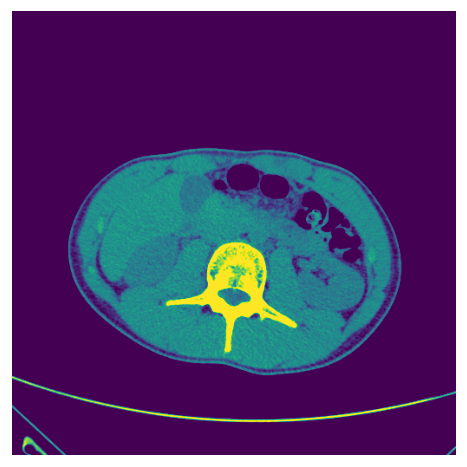

In [43]:
patient_folder = '/home/ubuntu/Anna_iliushina/some_files/dataset/10'
png_dataset = '/home/ubuntu/Anna_iliushina/some_files/png/10'
png_list = os.listdir(png_dataset)
#создание директории с номером пациента, если ее нет
if not os.path.exists(png_dataset):
    os.makedirs(png_dataset)
files_list = os.listdir(patient_folder)
# перебор всех файлов
for file in tqdm(files_list):
    file_path = os.path.join(patient_folder,file)
    png_name = file.split('.')[0] + '.png'
    if png_name in png_list:
        continue
    png_path = os.path.join(png_dataset,png_name)
    save_image(file_path,png_path)